In [1]:
import cmath
import numpy as np
import finesse
import finesse.components as fc
import finesse.detectors as det
from finesse.analysis.actions import FrequencyResponse

finesse.init_plotting()

In [2]:
L = 3994.5 # [m]
I = 0.757  # [kg.m^2]
c = 299792458 # [m.s^-1]
f_sus = 0.6 # [Hz]

model = finesse.Model()
model.fsig.f = 1 # set some initial signal frequency
model.modes(maxtem=1) # first order modes for modelling alignment signals

LASER = model.add(fc.Laser("LASER", P=1000))
# Add two mirrors for the cavity and attach a pendulum mechanics
M1 = model.add(fc.Mirror("M1", R=0.986, T=0.014, Rc=1934))
model.add(
    fc.mechanical.Pendulum(
        "M1_sus", model.M1.mech, mass=np.inf, I_yaw=np.inf, I_pitch=I, fpitch=f_sus
    )
)
M2 = model.add(fc.Mirror("M2", R=1, T=0, Rc=2245))
model.add(
    fc.mechanical.Pendulum(
        "M2_sus", model.M2.mech, mass=np.inf, I_yaw=np.inf, I_pitch=I, fpitch=f_sus
    )
)
model.connect(M1.p1, M2.p1, L=L)
model.connect(LASER.p1, M1.p2)
model.add(fc.Cavity('cavARM', M2.p1.o))
model.add(det.PowerDetector('P', M1.p1.o)); # cavity power

In [3]:
# Now we compute the decomposition of HARD and SOFT modes into motions of M1 and M2
g_1 = 1 - float(L / np.abs(M1.Rcx.value)) # input mirror g-factor
g_2 = 1 - float(L / np.abs(M2.Rcx.value)) # end mirror g-factor

r = model.add_parameter(
    'r',
    2 / ((g_1 - g_2) + np.sqrt((g_2 - g_1) ** 2 + 4)),
    description='r term in eq.3.5 in T0900511',
)

In [4]:
HARD = model.add(fc.DegreeOfFreedom("HARD", M1.dofs.F_pitch, -1, M2.dofs.F_pitch, +r.ref))
SOFT = model.add(fc.DegreeOfFreedom("SOFT", M1.dofs.F_pitch, +r.ref, M2.dofs.F_pitch, +1))

print(HARD.amplitudes)
print(SOFT.amplitudes)

[-1 ❮Symbolic='+r' @ 0x7f3a6697ba10❯]
[❮Symbolic='+r' @ 0x7f3a6515f7a0❯ 1]


In [5]:
print("model.r = ", model.r.eval())
print("Current HARD amplutudes:", HARD.amplitudes.astype(float))

model.r =  1.1532419233817137
Current HARD amplutudes: [-1.          1.15324192]


In [6]:
print(repr(model.M1.dofs.F_pitch.AC_IN))
print(repr(model.M1.dofs.F_pitch.AC_OUT))
print(repr(model.M1.dofs.F_pitch.DC))

❮SignalNode M1.mech.F_pitch @ 0x7f3a66926870❯
❮SignalNode M1.mech.pitch @ 0x7f3a669267e0❯
❮M1.ybeta=((-HARD.DC)+(SOFT.DC*r)) @ 0x7f3a66bb7580❯


In [7]:
LASER.P = 1410 * 3/2 # get to roughly 600kW
freq_resp = FrequencyResponse(
    np.geomspace(0.1, 10, 2000),
    [HARD.AC.i, SOFT.AC.i],
    [HARD.AC.o, SOFT.AC.o],
)
sol = model.run(freq_resp)
# Alsp compute a single data point of the detectors to compute the power
# circulating in the cavity
out = model.run()
print(sol.out.shape)

(2000, 2, 2)


Text(0, 0.5, 'Magnitude [dB - rad/Nm]')

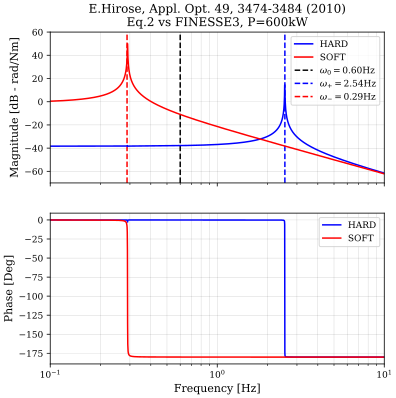

In [8]:
omega_0 = 2 * np.pi * f_sus
P = out['P']
# Eq 2 from https://opg.optica.org/ao/fulltext.cfm?uri=ao-49-18-3474
omega_plus = np.sqrt(
    omega_0**2 + P * L / (I * c) * (-(g_1 + g_2) + cmath.sqrt(4+(g_1 - g_2)**2))/ (1 - g_1*g_2)
)
omega_minus = np.sqrt(
    omega_0**2 + P * L / (I * c) * (-(g_1 + g_2) - cmath.sqrt(4+(g_1 - g_2)**2))/ (1 - g_1*g_2)
)

axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
axs = finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)
axs[0].vlines(omega_0/2/np.pi, -70, 60, ls='--', label=f'$\\omega_{{0}} = {omega_0.real/2/np.pi:0.2f}$Hz', color='k', zorder=-100)
axs[0].vlines(omega_plus.real/2/np.pi, -70, 60, ls='--', label=f'$\\omega_{{+}} = {omega_plus.real/2/np.pi:0.2f}$Hz', zorder=-100)
axs[0].vlines(omega_minus.real/2/np.pi, -70, 60, color='red', ls='--', label=f'$\\omega_{{-}} = {omega_minus.real/2/np.pi:0.2f}$Hz', zorder=-100)
axs[0].margins(0)
axs[0].set_title(f"E.Hirose, Appl. Opt. 49, 3474-3484 (2010)\nEq.2 vs FINESSE3, P={P/1e3:0.0f}kW")
axs[0].legend()
axs[0].set_ylabel("Magnitude [dB - rad/Nm]")

array([<Axes: ylabel='Magnitude [dB]'>,
       <Axes: xlabel='Frequency [Hz]', ylabel='Phase [Deg]'>],
      dtype=object)

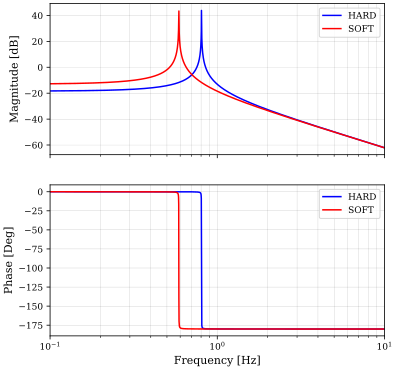

In [9]:
LASER.P = 100
sol = model.run(freq_resp)
axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)

array([<Axes: ylabel='Magnitude [dB]'>,
       <Axes: xlabel='Frequency [Hz]', ylabel='Phase [Deg]'>],
      dtype=object)

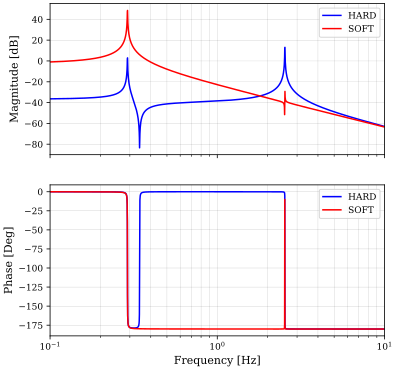

In [10]:
LASER.P = 1410 * 3/2 # get to roughly 600kW
model.r = 1
# Or alternatively you can replace the amplitudes directly with something like
# HARD.amplitudes[:] = [-1, +1]
# SOFT.amplitudes[:] = [+1, +1]
sol = model.run(freq_resp)
axs = finesse.plotting.bode(sol.f, sol['HARD.AC.i', 'HARD.AC.o'], label='HARD')
finesse.plotting.bode(sol.f, sol['SOFT.AC.i', 'SOFT.AC.o'], label='SOFT', axs=axs)